# Motion Estimation and Correction in PyTorch

Let's start by loading some example data with simulated beam-induced motion

source: https://zenodo.org/records/15617030

In [5]:
# https://github.com/fatiando/pooch
from pathlib import Path
import pooch

IMAGE_FILE_NAME = "EMPIAR-10164-image-0deg-with-simulated-deformations.mrc"
GOODBOY = pooch.create(
    path=pooch.os_cache("torch-motion-correction"),
    base_url="doi:10.5281/zenodo.15617030/",
    registry={
        IMAGE_FILE_NAME: "md5:cfb20be0a4a8511009330bc50a7f3cb0",
    },
)

image_file = Path(GOODBOY.fetch(IMAGE_FILE_NAME, progressbar=True))
pixel_spacing = 5.4

Image shape: (40, 959, 927)


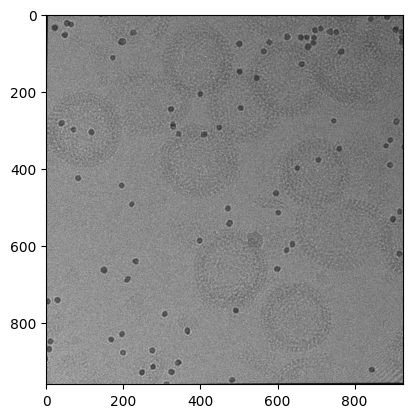

In [7]:
import mrcfile
import matplotlib.pyplot as plt

image = mrcfile.read(image_file)
print(f"Image shape: {image.shape}")

fig, ax = plt.subplots()
ax.imshow(image[20], cmap="gray")
plt.show()

In [9]:
import torch
from torch_motion_correction import estimate_motion

image = torch.as_tensor(image).float()
deformation_grid = estimate_motion(
    image=image,
    pixel_spacing=pixel_spacing,
    deformation_field_resolution=(20, 5, 5),  # (nt, nh, nw)
    frequency_range=(300, 10),  # angstroms
    patch_sidelength=128,  # (512 is a better default for full size images)
    n_patches_per_batch=20,
    learning_rate=0.05,
    n_iterations=500
)  # (2, nt, nh, nw)
print(deformation_grid.shape)

/Users/aburt/Projects/torch-motion-correction/.venv/lib/python3.13/site-packages/torch_cubic_spline_grids/_base_cubic_grid.py:40: FutureWarning: functools.partial will be a method descriptor in future Python versions; wrap it in staticmethod() if you want to preserve the old behavior
  self._interpolation_function(


0: loss = 2653.2060546875
10: loss = 2512.576904296875
20: loss = 3527.280517578125
30: loss = 4358.2900390625
40: loss = 3417.64453125
50: loss = 3610.609130859375
60: loss = 3296.968505859375
70: loss = 3830.52490234375
80: loss = 3486.876953125
90: loss = 3211.80712890625
100: loss = 3292.026123046875
110: loss = 3352.50927734375
120: loss = 3032.17578125
130: loss = 3325.820556640625
140: loss = 2353.107421875
150: loss = 2963.8154296875
160: loss = 3912.760009765625
170: loss = 3299.1875
180: loss = 2332.6728515625
190: loss = 2864.833251953125
200: loss = 2448.22314453125
210: loss = 4321.28173828125
220: loss = 3012.613525390625
230: loss = 2823.265869140625
240: loss = 3770.294677734375
250: loss = 3145.60546875
260: loss = 1756.1334228515625
270: loss = 3821.84716796875
280: loss = 2588.142578125
290: loss = 2715.61376953125
300: loss = 3318.343017578125
310: loss = 3307.786376953125
320: loss = 2788.592041015625
330: loss = 3046.919921875
340: loss = 2168.15478515625
350: los

In [13]:
from torch_motion_correction import correct_motion

motion_corrected = correct_motion(
    image=image,
    pixel_spacing=pixel_spacing,
    deformation_grid=deformation_grid
)
print(motion_corrected.shape)

/Users/aburt/Projects/torch-motion-correction/.venv/lib/python3.13/site-packages/torch_cubic_spline_grids/_base_cubic_grid.py:40: FutureWarning: functools.partial will be a method descriptor in future Python versions; wrap it in staticmethod() if you want to preserve the old behavior
  self._interpolation_function(


torch.Size([40, 959, 927])


torch.Size([959, 927])


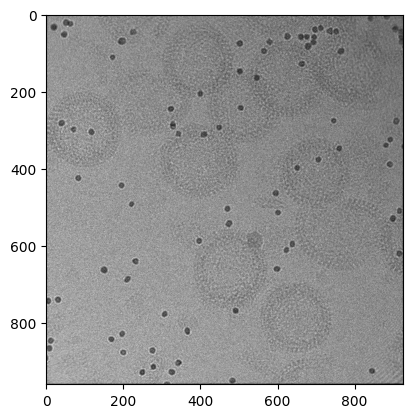

In [14]:
motion_corrected = torch.mean(motion_corrected, dim=0)
print(motion_corrected.shape)

fig, ax = plt.subplots()
ax.imshow(motion_corrected.detach().numpy(), cmap="gray")
plt.show()